In [66]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from utils import ProgBar

# Parameters

In [67]:
h = 0.01
k = 0.1
Db = 0.0001
Dn = 0.0001
phi = 0.2
ksi = 0.0
cp = 0.154
lambd_nb = 40
mi_n = 0.2
lambd_bn = 0.1
X_nb = 0.0001
y_n = 0.1
C_nmax = 0.55

x_dom = (0, 1)
y_dom = (0, 1)
t_dom = (0, 10)

size_x = int(((x_dom[1] - x_dom[0]) / (h)))
size_y = int(((y_dom[1] - y_dom[0]) / (h)))
size_tt = int(((t_dom[1] - t_dom[0]) / (k)))

x = np.linspace((x_dom[1], x_dom[0]), size_x)
y = np.linspace((y_dom[1], y_dom[0]), size_y)
t = np.linspace((t_dom[1], t_dom[0]), size_tt)

print("Size x = {:d}, y = {:d} \n ".format(size_x, size_y))

print(
    "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
        size_tt,
        size_x,
        size_y,
    )
)

CFL = ((Db * k) / ((2 * (h * h))))

print("CFL: ",CFL)
if CFL >= 1:
    print("Criterio não satisfeito")

Size x = 100, y = 100 
 
Steps in time = 100
Steps in space_x = 100
Steps in space_y = 100

CFL:  0.05


# Model definition

In [68]:
class PINN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(3, 64),
            nn.Sigmoid(),
            nn.Linear(64, 64),
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [69]:
def gerenate_training(num_points):
    x1 = torch.rand(num_points, 1)
    y1 = torch.rand(num_points, 1)
    t = torch.rand(num_points, 1)
    x_e = 0.5 + torch.rand(num_points) * (0.6 - 0.5)
    y_e = 0.5 + torch.rand(num_points) * (0.6 - 0.5)
    x = torch.cat([x1, x_e.view(-1,1)], dim=0)
    y = torch.cat(
        [y1, y_e.view(-1,1)],
        dim=0,
    )

    return x, y, t


def gerenate_initial(num_points):
    x1 = torch.rand(num_points // 4, requires_grad=True) * 0.5
    y1 = torch.rand(num_points // 4, requires_grad=True) * 0.5

    x2 = 0.6 + torch.rand(num_points // 4, requires_grad=True) * (1 - 0.6)
    y2 = 0.6 + torch.rand(num_points // 4, requires_grad=True) * (1 - 0.6)

    x1 = torch.rand(num_points // 4, requires_grad=True) * 0.5
    y1 = torch.rand(num_points // 4, requires_grad=True) * 0.5

    x2 = 0.6 + torch.rand(num_points // 4, requires_grad=True) * (1 - 0.6)
    y2 = 0.6 + torch.rand(num_points // 4, requires_grad=True) * (1 - 0.6)

    x_e = 0.5 + torch.rand(num_points, requires_grad=True) * (0.6 - 0.5)
    y_e = 0.5 + torch.rand(num_points, requires_grad=True) * (0.6 - 0.5)

    x = torch.cat([x1, x2, x1, x2, x_e, x_e, torch.cat([x1, x2], dim=0)], dim=0)
    y = torch.cat(
        [y1, y2, y2, y1, y_e, torch.cat([y1, y2], dim=0), y_e],
        dim=0,
    )

    return x.view(-1, 1), y.view(-1, 1)

In [70]:
def initial_condition(x, y):

    Cl = torch.full_like(x, 0)

    Cp = torch.full_like(x, 0)

    for i, (xx, yy) in enumerate(zip(x, y)):
        if ((xx >= 0.5) and (xx <= 0.6)) and ((yy >= 0.5) and (yy <= 0.6)):
            Cp[i] = 0.2


    return Cl, Cp

In [71]:
def gerenate_boundary_training_data(num_points, direction="x"):

    x_boundary = torch.tensor([0, 1]).repeat(num_points // 2)
    y_boundary = torch.rand(num_points, requires_grad=True)

    if direction == "y":
        x_boundary, y_boundary = y_boundary, x_boundary
        n_boundary = torch.tensor([0, -1, 0, 1])
        n_boundary = n_boundary.repeat(num_points // 2)

    else:
        n_boundary = torch.tensor([-1, 0, 1, 0])
        n_boundary = n_boundary.repeat(num_points // 2)

    t = torch.rand(num_points, 1, requires_grad=True)

    return (
        x_boundary.view(-1, 1),
        y_boundary.view(-1, 1),
        t.view(-1, 1),
        n_boundary.view(-1, 2),
    )

In [72]:
def boundary_condition(x_b, y_b, t_b, n, model, custom_value=0):
    input_data = torch.cat([x_b, y_b, t_b], dim=1)

    Cp, Cl = model(input_data).tensor_split(2, dim=1)

    ny, nx = n.tensor_split(2, dim=1)

    if nx[0].item() != 0:
        dCp_dx = torch.autograd.grad(
            Cp,
            x_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )
        dCl_dx = torch.autograd.grad(
            Cl,
            x_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = (
            torch.mul(((Dn * dCl_dx[0]) - X_nb * torch.mul(Cl, dCp_dx[0])), nx)
            - custom_value
        )
        Cp_boundary = torch.mul((Db * dCp_dx[0]), nx) - custom_value

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

    else:
        dCp_dy = torch.autograd.grad(
            Cp,
            y_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )
        dCl_dy = torch.autograd.grad(
            Cl,
            y_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = (
            torch.mul(((Dn * dCl_dy[0]) - X_nb * torch.mul(Cl, dCp_dy[0])), ny)
            - custom_value
        )
        Cp_boundary = torch.mul((Db * dCp_dy[0]), ny) - custom_value

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

In [73]:
def pde(x, y, t, model):
    input_data = torch.cat([x, y, t], dim=1)

    Cl, Cp = model(input_data).tensor_split(2, dim=1)

    # Calculating Cp value

    dCp_dx, dCp_dy = torch.autograd.grad(
        Cp,
        [x, y],
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )

    dCp_dx_2 = torch.autograd.grad(
        dCp_dx,
        x,
        grad_outputs=torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dy_2 = torch.autograd.grad(
        dCp_dy,
        y,
        grad_outputs=torch.ones_like(dCp_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    qb = cp * Cp
    rb = lambd_nb * torch.mul(Cl, Cp)

    Cp_eq = Db * (dCp_dx_2 + dCp_dy_2) - rb + qb - dCp_dt

    # Calculating Cl value

    dCl_dx, dCl_dy = torch.autograd.grad(
        Cl,
        [x, y],
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )

    dCl_dx_2 = torch.autograd.grad(
        dCl_dx,
        x,
        grad_outputs=torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dy_2 = torch.autograd.grad(
        dCl_dy,
        y,
        grad_outputs=torch.ones_like(dCl_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    qn = y_n * torch.mul(Cp, (C_nmax - Cl))
    rn = lambd_bn * torch.mul(Cl, Cp) + mi_n * Cl

    Cl_eq = (
        Dn * (dCl_dx_2 + dCl_dy_2)
        - X_nb
        * (
            (torch.mul(dCl_dx, dCp_dx) + torch.mul(Cl, dCp_dx_2))
            + (torch.mul(dCl_dy, dCp_dy) + torch.mul(Cl, dCp_dy_2))
        )
        - rn
        + qn
    ) - dCl_dt
    
    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [74]:
def train_PINN(model, num_iterations, num_points):

    # Initializing optimator
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Declaring exponential decay

    decay_rate = 0.985

    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

    C_initial_loss_it = []
    C_boundary_loss_it = []
    C_loss_it = []

    bar = ProgBar(num_iterations, "Rodando épocas...")

    for it in range(num_iterations):
        optimizer.zero_grad()

        x, y, t = gerenate_training(num_points)
        # xi, yi = gerenate_initial(num_points)

        t_initial = torch.zeros_like(x)
        Cl_initial, Cp_initial = initial_condition(x, y)

        # x_b_x, y_b_x, t_b_x, n_x = gerenate_boundary_training_data(num_points)

        # x_b_y, y_b_y, t_b_y, n_y = gerenate_boundary_training_data(
        #     num_points, direction="y"
        # )

        # C_boundary_x = boundary_condition(x_b_x, y_b_x, t_b_x, n_x, model)

        # C_boundary_y = boundary_condition(x_b_y, y_b_y, t_b_y, n_y, model)

        # C = pde(x, y, t, model)

        input_inicial = torch.cat([x, y, t_initial], dim=1)

        C_initial_pred = model(input_inicial)

        # Cl_initial_loss = nn.MSELoss()(Cl_initial, C_initial_pred[:, 0])
        Cp_initial_loss = 2*nn.MSELoss()(Cp_initial, C_initial_pred)

        # return input_inicial, C_initial, C_initial_pred

        # C_boundary_loss = nn.MSELoss()(
        #     C_boundary_x, torch.zeros_like(C_boundary_x)
        # ) + nn.MSELoss()(C_boundary_y, torch.zeros_like(C_boundary_y))

        # C_loss = nn.MSELoss()(C, torch.zeros_like(C))

        # loss = C_initial_loss + C_boundary_loss + C_loss
        loss =  Cp_initial_loss

        loss.backward(retain_graph=True)
        optimizer.step()
        lr_scheduler.step()

        # C_boundary_loss_it.append(C_boundary_loss.item())
        # C_loss_it.append(C_loss.item())
        # C_initial_loss_it.append(C_initial_loss.item())

        bar.update()

    return input_inicial, Cl_initial, Cp_initial, C_initial_pred
    return C_boundary_loss_it, C_initial_loss_it, C_loss_it

In [75]:
model = PINN()

n_iterations = 300

input_inicial, Cl_initial, Cp_initial, C_initial_pred = train_PINN(
    model, n_iterations, 2**10
)

Rodando épocas...
[--------------------------------------------------] 100.00% - 300 of 300

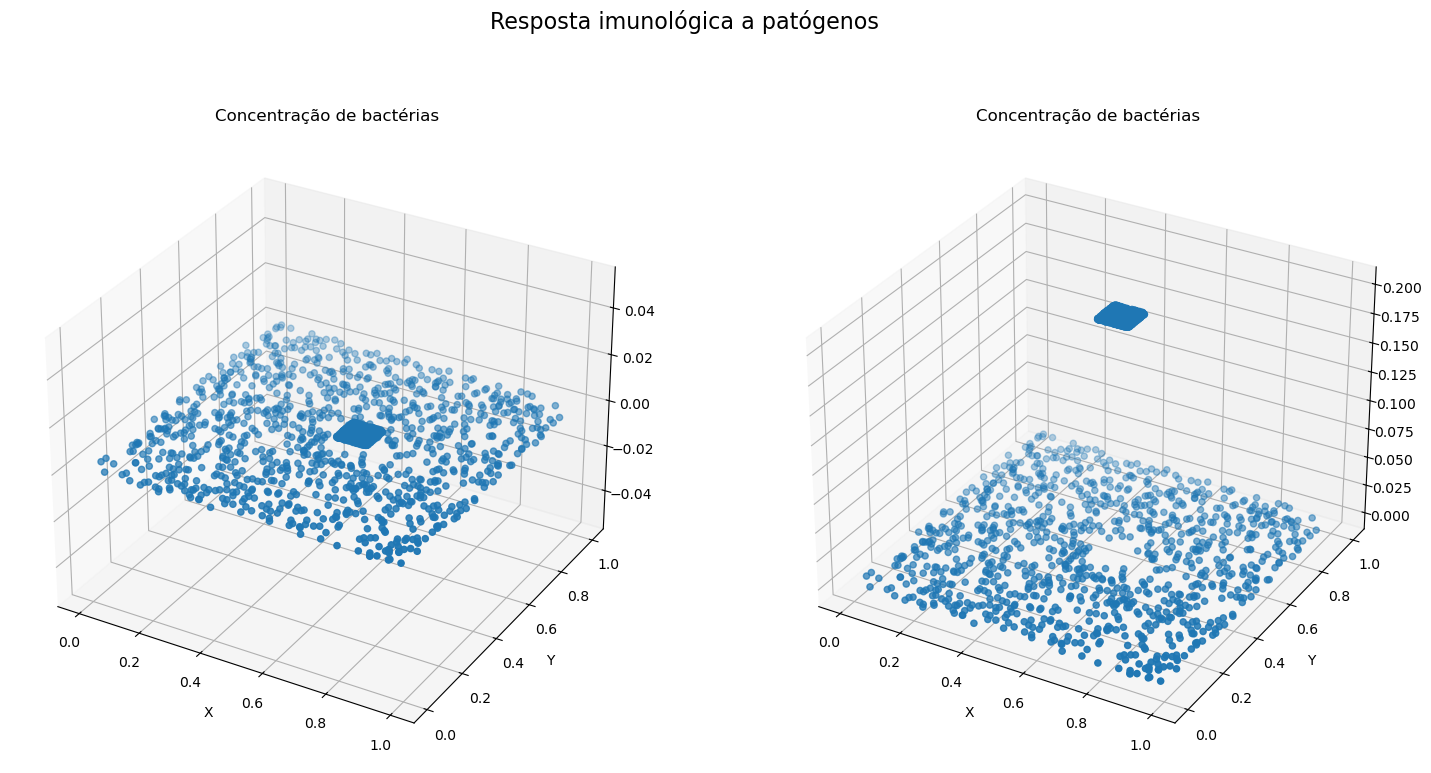

In [76]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle('Resposta imunológica a patógenos', fontsize=16)

# X, Y, Z = torch.meshgrid(malha[:,0].numpy(),malha[:,1].numpy(),C_initial[:,0].numpy())

# vmin = 0
# vmax = np.max([torch.max(Cp),torch.max(Cl)])

# Plotango 3D
ax = fig.add_subplot(1, 2, 1,projection='3d')

ax.scatter(input_inicial[:,0].detach().numpy(),input_inicial[:,1].detach().numpy(),Cl_initial.detach().numpy())
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Plotando 2D
# Plotango 3D
ax = fig.add_subplot(1, 2, 2,projection='3d')

ax.scatter(input_inicial[:,0].detach().numpy(),input_inicial[:,1].detach().numpy(),Cp_initial.detach().numpy())
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

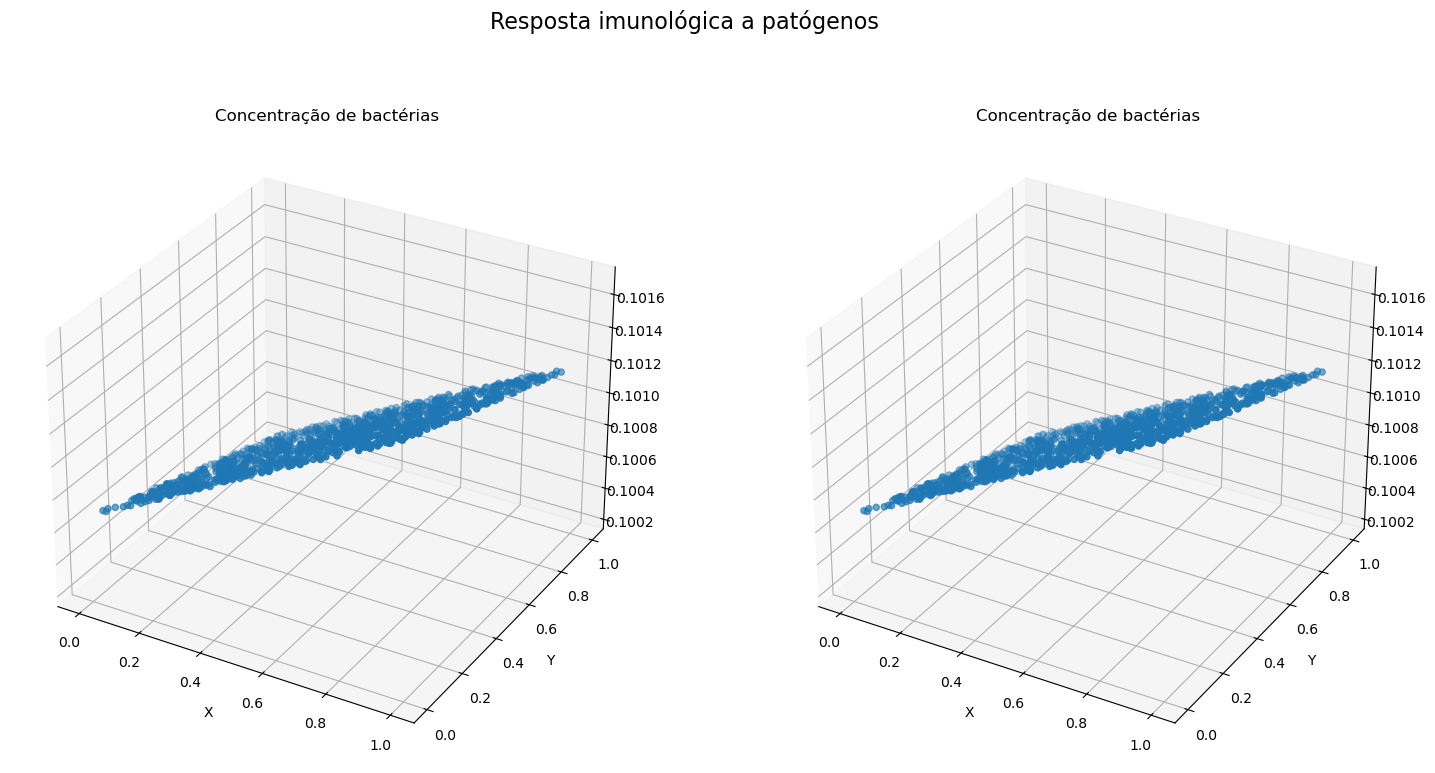

In [77]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle('Resposta imunológica a patógenos', fontsize=16)

# X, Y, Z = torch.meshgrid(malha[:,0].numpy(),malha[:,1].numpy(),C_initial[:,0].numpy())

# vmin = 0
# vmax = np.max([torch.max(Cp),torch.max(Cl)])

# Plotango 3D
ax = fig.add_subplot(1, 2, 1,projection='3d')

ax.scatter(input_inicial[:,0].detach().numpy(),input_inicial[:,1].detach().numpy(),C_initial_pred[:,0].detach().numpy())
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Plotando 2D
# Plotango 3D
ax = fig.add_subplot(1, 2, 2,projection='3d')

ax.scatter(input_inicial[:,0].detach().numpy(),input_inicial[:,1].detach().numpy(),C_initial_pred.detach().numpy())
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

In [78]:
model = PINN()

n_iterations = 400

C_boundary_loss_it, C_initial_loss_it, C_loss_it = train_PINN(
    model, n_iterations, 2**9
)

Rodando épocas...
[--------------------------------------------------] 100.00% - 400 of 400

ValueError: too many values to unpack (expected 3)

NameError: name 'C_loss_it' is not defined

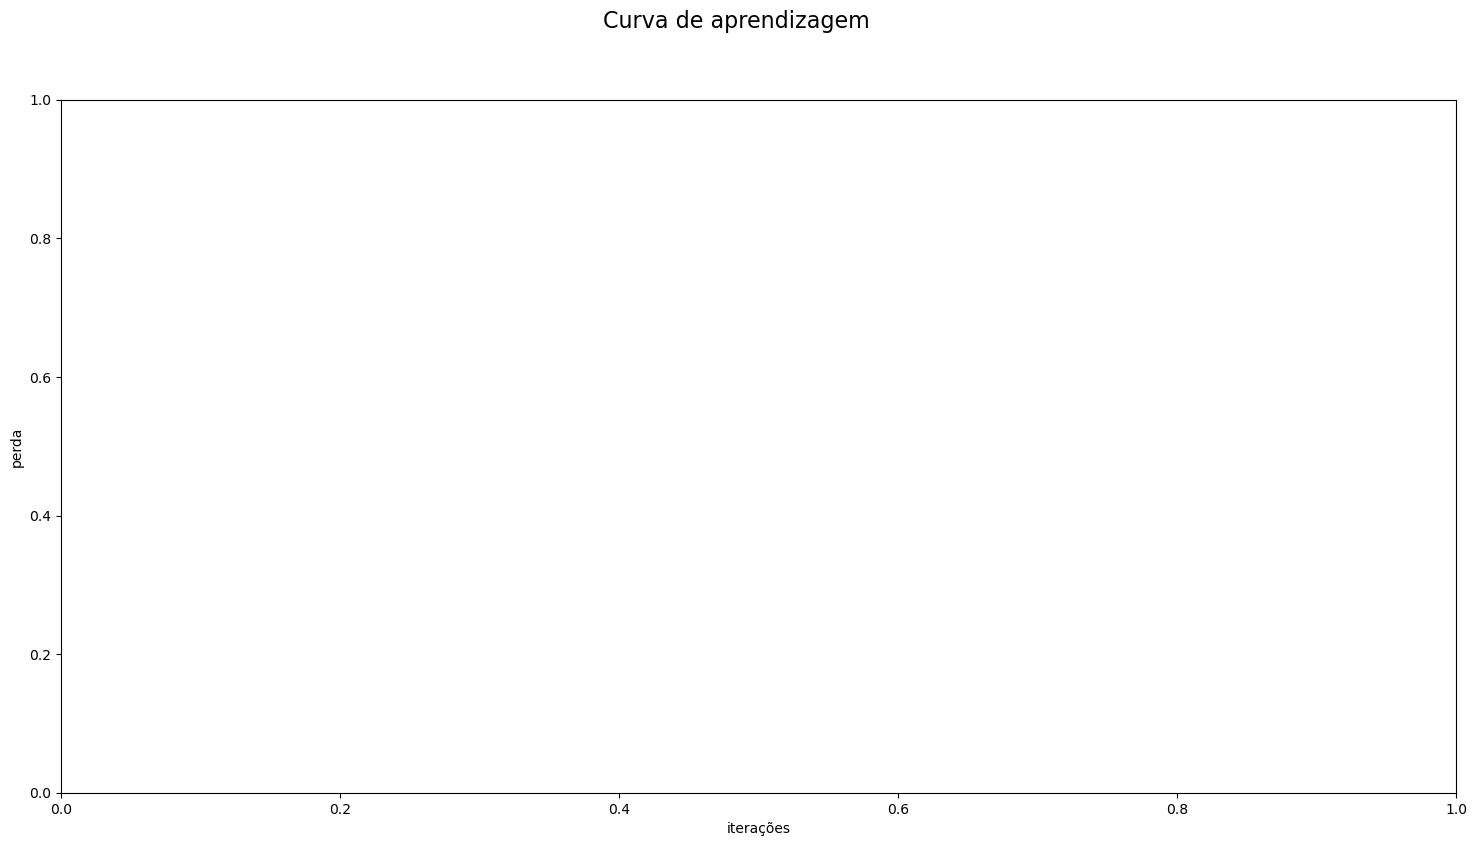

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle('Curva de aprendizagem', fontsize=16)


# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(range(len(C_loss_it)),C_loss_it,label="Equation loss")
ax.plot(range(len(C_boundary_loss_it)),C_boundary_loss_it,label="Boundary loss")
ax.plot(range(len(C_initial_loss_it[:300])),C_initial_loss_it[:300],label="Initial loss")
# ax.set_yscale("log")
ax.grid()
ax.legend()


plt.show()

In [ ]:
C_boundary_loss_it[-1]+C_initial_loss_it[-1]+C_loss_it[-1]

IndexError: list index out of range

In [ ]:
# t_vals = torch.linspace(0, 1, size_tt)
t_vals = [0]
x_vals = torch.linspace(0, 1, size_x)
y_vals = torch.linspace(0, 1, size_x)
X, Y = torch.meshgrid(x_vals, y_vals)


for t in t_vals:
    with torch.no_grad():

        t_val = torch.ones_like(X) * 0  # specify time

        input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)

        solution = model(input_data)

        Cl,Cp = solution.tensor_split(2, dim=1)
        Cl = Cl.reshape(X.shape, Y.shape)
        Cp = Cp.reshape(X.shape, Y.shape)



In [79]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle('Resposta imunológica a patógenos', fontsize=16)

X, Y = np.meshgrid(x_vals.numpy(),y_vals.numpy())

# vmin = 0
# vmax = np.max([torch.max(Cp),torch.max(Cl)])

# Plotango 3D
ax = fig.add_subplot(1, 2, 1)

contour = ax.contourf(X, Y, Cp[0], cmap="jet")
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")
colobar = fig.colorbar(contour)

# Plotando 2D

ax = fig.add_subplot(1, 2, 2)

contour = ax.contourf(X, Y, Cl, cmap="jet")
ax.set_title("Concentração de neutrófilos")
ax.set_xlabel("X")
ax.set_ylabel("Y")

colobar = fig.colorbar(contour)

plt.show()

NameError: name 'x_vals' is not defined

<Figure size 1800x900 with 0 Axes>